In [1]:
# Import chunk of things
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm

## Map Plotting imports

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'm01s50i062'
stash_mass = 'm01s50i063'
stash_temp = 'surface_temperature'

#define functions
def molec_cm3(conc_kg_kg, mass, vol, mr):
    molec_box = conc_kg_kg*mass/mr*1000*n_a #molecules per box
    cm3 = molec_box/(vol*1e6) #molec per cm3
    return cm3

def moving_average(x, months):
    return np.convolve(x, np.ones(months), 'valid') / months

#define constants
n_a = 6.02e23
oh_mr = 17

In [2]:
# Altitude data to obtain volumes

data_alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = data_alt.grid_cell_volume
vol = vol.data

In [3]:
#### Fetch data
oh_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_oh.nc',chunks={'time':24})
oh_443 = oh_data_443.oh[:]

lat = oh_data_443.latitude[:]
lon = oh_data_443.longitude[:]
time = oh_data_443.time[:]

trop_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_trop_mask.nc',chunks={'time':24})

airmass_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_airmass_atm.nc',chunks={'time':24})
airmass_443 = airmass_data_443.airmass_atm

In [4]:
# trop mask on oh data

trop_data_443['mask'] = xr.ones_like(trop_data_443.trop_mask)
trop_data_443['mask'] = trop_data_443.mask.where(trop_data_443.trop_mask>=0.9999,other=0.)

# oh_mask_949 = ma.masked_where(trop_mask_949>=0.999999,oh_949)

In [5]:
# calculate trop mean oh
oh_conc_cm3 = molec_cm3(oh_443,airmass_443,vol,oh_mr)
airm_weights = trop_data_443.mask*airmass_443
oh_trop_443 = dd.array.average(oh_conc_cm3,weights=airm_weights,axis=1)

In [6]:
# define weights then create a grid of scaled values with sqrt(cos(latitude))
weight_lat = np.sqrt(np.abs(np.cos(np.deg2rad(lat))))
weight_grid_lonlat = np.tile(weight_lat,(192,1))
w_use = weight_grid_lonlat.transpose()

In [7]:
# for some reason doesn't like to do the analysis on the dask array, gives an error about missing values and wrong size covariance matrices, but computing into a numpy array works fine
oh_comp = oh_trop_443.compute()

In [8]:
# eof analysis
from eofs.standard import Eof

solver = Eof(oh_comp,weights=w_use)

In [9]:
eofs = solver.eofsAsCorrelation(neofs=5)

pcs = solver.pcs(npcs=5,pcscaling=1)

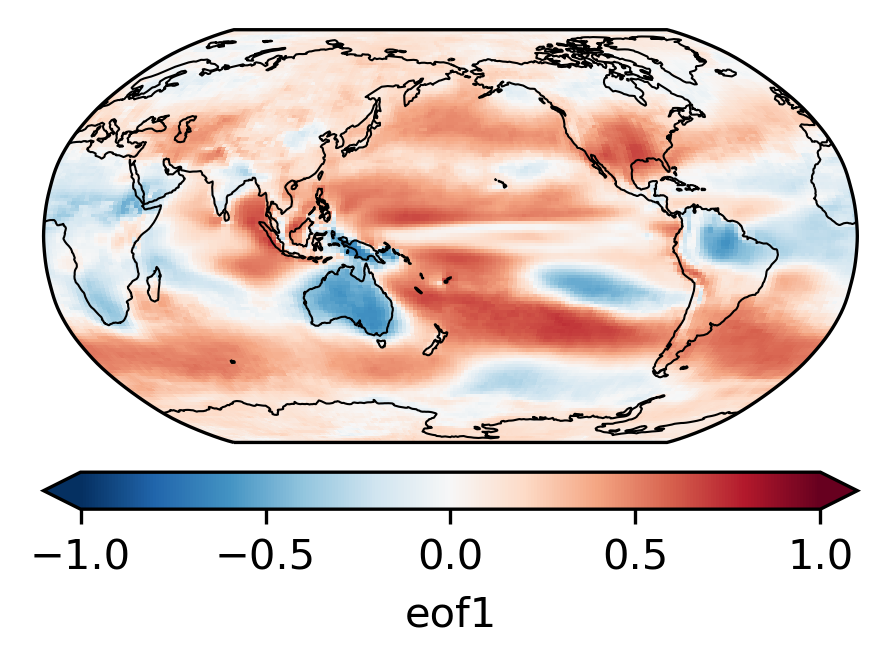

In [10]:
# show 1st eof on a map
fig = plt.figure(figsize=(3.5,2.625), dpi=300)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=180, globe=None))
ax.set_global()
ax.coastlines(linewidth=0.5)

eof_cyclic, lon_plot = add_cyclic_point(eofs[0,:,:], coord=lon)   


plt.pcolormesh(lon_plot,lat,eof_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0), vmin=-1, vmax=1)

plt.colorbar(label = 'eof1' ,orientation='horizontal',pad=0.05, extend='both')

In [11]:
oh_trop_mean_443 = dd.array.average(oh_conc_cm3,weights=airm_weights,axis=(1,2,3))

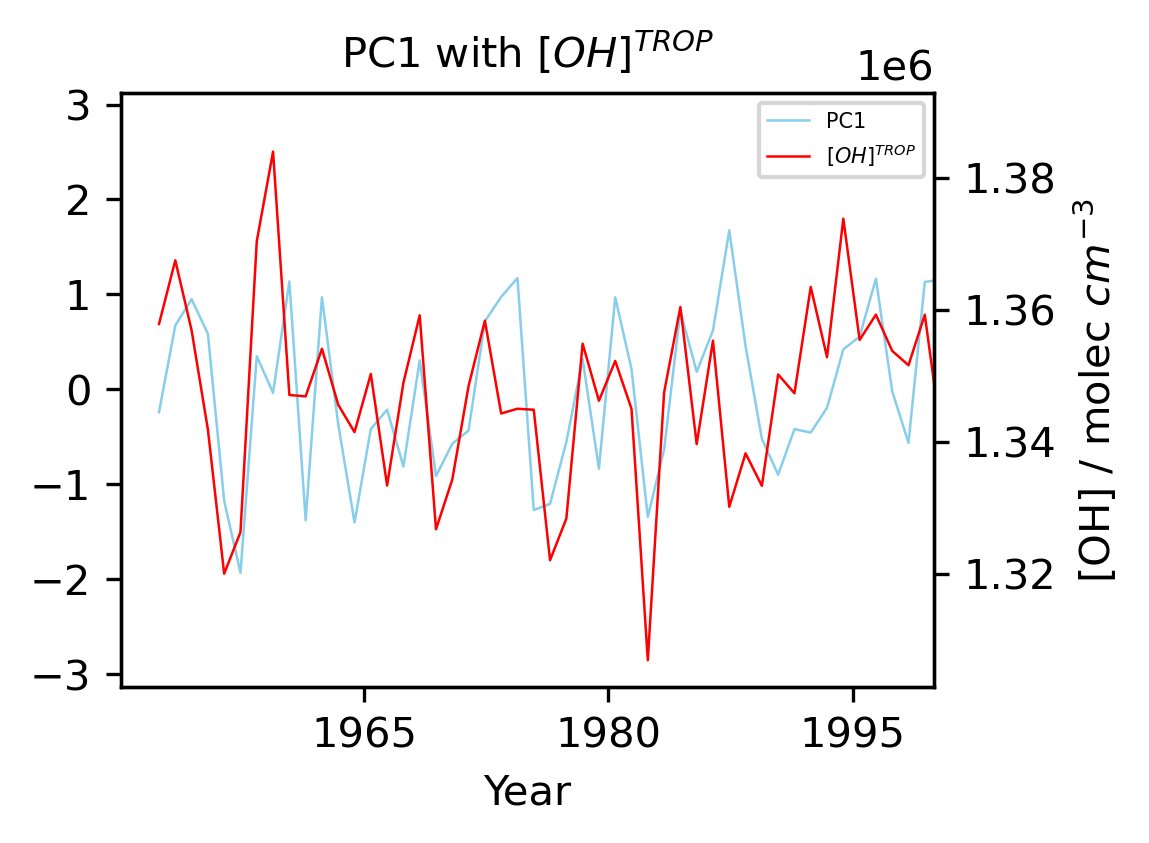

In [12]:
# Plot of 1st pc and airmass weighted [OH]

fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

plt.xlabel("Year")
ax.set_ylabel("", fontsize=8)
plt.title("PC1 with $[OH]^{TROP}$", fontsize=10)

ax1 = ax.twinx()
ax1.set_ylabel('[OH] / molec $cm^{-3}$')
ax.set_xlim(-17980,0)

line0, = ax.plot(time, pcs[:,0], c='skyblue', linewidth=0.6, label = 'PC1')
line1, = ax1.plot(time, oh_trop_mean_443, c='red', linewidth=0.6, label = '$[OH]^{TROP}$')
ax.legend(handles=[line0,line1],fontsize=5,loc ='upper right')

In [13]:
fractions = solver.varianceFraction(neigs=5)
print(fractions)

[0.12809139 0.09937894 0.04705502 0.03713551 0.02633017]


In [14]:
## Plot temperature in NINO3.4

temp_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_tas_monthly.nc')
temp_443 = temp_data_443.surface_temp
lat = temp_data_443.latitude
lon = temp_data_443.longitude
time_443 = temp_data_443.time

In [15]:
# apply nino3.4 mask to data
nino34_temp = temp_443.loc[:,-5:5,190:240]
nino_mean_443 = np.mean(nino34_temp,axis=(1,2))

# temp_data_443['mask'] = xr.ones_like(temp_443)
# temp_data_443['mask'] = temp_data_443.mask.where(np.abs(temp_443.latitude)<5,other=0.) 
# temp_data_443['mask'] = temp_data_443.mask.where(temp_443.longitude<240,other=0.)
# temp_data_443['mask'] = temp_data_443.mask.where(temp_443.longitude>190,other=0.)
# enso_443 = ma.masked_where(temp_data_443.mask!=1,temp_443)
# nino_mean_443 = np.mean(enso_443,axis=(1,2))

In [16]:
# Plot of temperature in the NINO3.4 region

# fig = plt.figure(figsize=(3.5,2.625), dpi=300)
# ax = plt.axes()

# plt.xlabel("Year")
# ax.set_ylabel("temp", fontsize=8)
# plt.title("NINO3.4 temperature mean", fontsize=10)


# line0, = ax.plot(time_443, nino_mean_443, c='skyblue', linewidth=0.6)

In [17]:
# show 1st eof on a map
# fig = plt.figure(figsize=(3.5,2.625), dpi=300)

# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0, globe=None))
# ax.set_global()
# ax.coastlines(linewidth=0.5)

# eof_cyclic, lon_plot = add_cyclic_point(np.mean(enso_443,axis=0), coord=lon)   

# plt.pcolormesh(lon_plot,lat,eof_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0))#, vmin=-1, vmax=1)

# plt.colorbar(label = 'nino3.4 temp' ,orientation='horizontal',pad=0.05, extend='both')

In [18]:
## calculate 3 month mean for enso data

bh443_3monmean = moving_average(nino_mean_443,3)
bh443_25yrmean = moving_average(nino_mean_443,300)
# bh443_30yrmean = moving_average(nino_mean_443,360)

temp_anomaly_bh443 = bh443_3monmean[:3289] - bh443_25yrmean

dtime_443 = nc.date2num(time_443[:3289],'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

# # Alternative temperature anomaly calculation
# # note doing it this way does cause some error at the edges, but does make the datasets the same length, which is convienient

# # bl949_3monmean = moving_average(nino_mean_949,3)
# bh443_3monmean = nino_mean_443.rolling(time=3,min_periods=1,center=True).mean()

# # da.rolling(time=3, center=True).mean().dropna("time")

# # bl949_30yrmean = moving_average(nino_mean_949,360)
# bh443_30yrmean = nino_mean_443.rolling(time=360,min_periods=1,center=True).mean()

# temp_anomaly_bh443 = bh443_3monmean - bh443_30yrmean

# dtime_443 = nc.date2num(time_443,'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

In [19]:
# Calculate OH and PC correlation 
res = np.empty

for i in range(0,273):
    av = np.mean(temp_anomaly_bh443[i*12:(i+1)*12])
    res = np.append(res,av)

av = np.mean(temp_anomaly_bh443[3276:3289])
res = np.append(res,av)
res = np.delete(res,0)

# Pearson correlation data, returns statistical as (r,p)

pcsuse = pcs[:274,0]
# pcsuse = pcs[27:,0]

#######################################################################

from scipy.stats.stats import pearsonr
stat = pearsonr(pcsuse,res)

print(stat)

(-0.7271929923510173, 2.376372875255677e-46)


In [21]:
# Test the output for the 100 years from the monthly data

test_pc = pcs[198:274,0]
# pcsuse = pcs[27:,0]
test_temp = res[:76]

#######################################################################

from scipy.stats.stats import pearsonr
stat = pearsonr(test_pc,test_temp)

print(stat)

(0.06262577600077325, 0.5909647169914028)


Text(0.5, 1.0, 'Plot showing weak correlation in region considered in the 100 year monthly data, r = 0.0626')

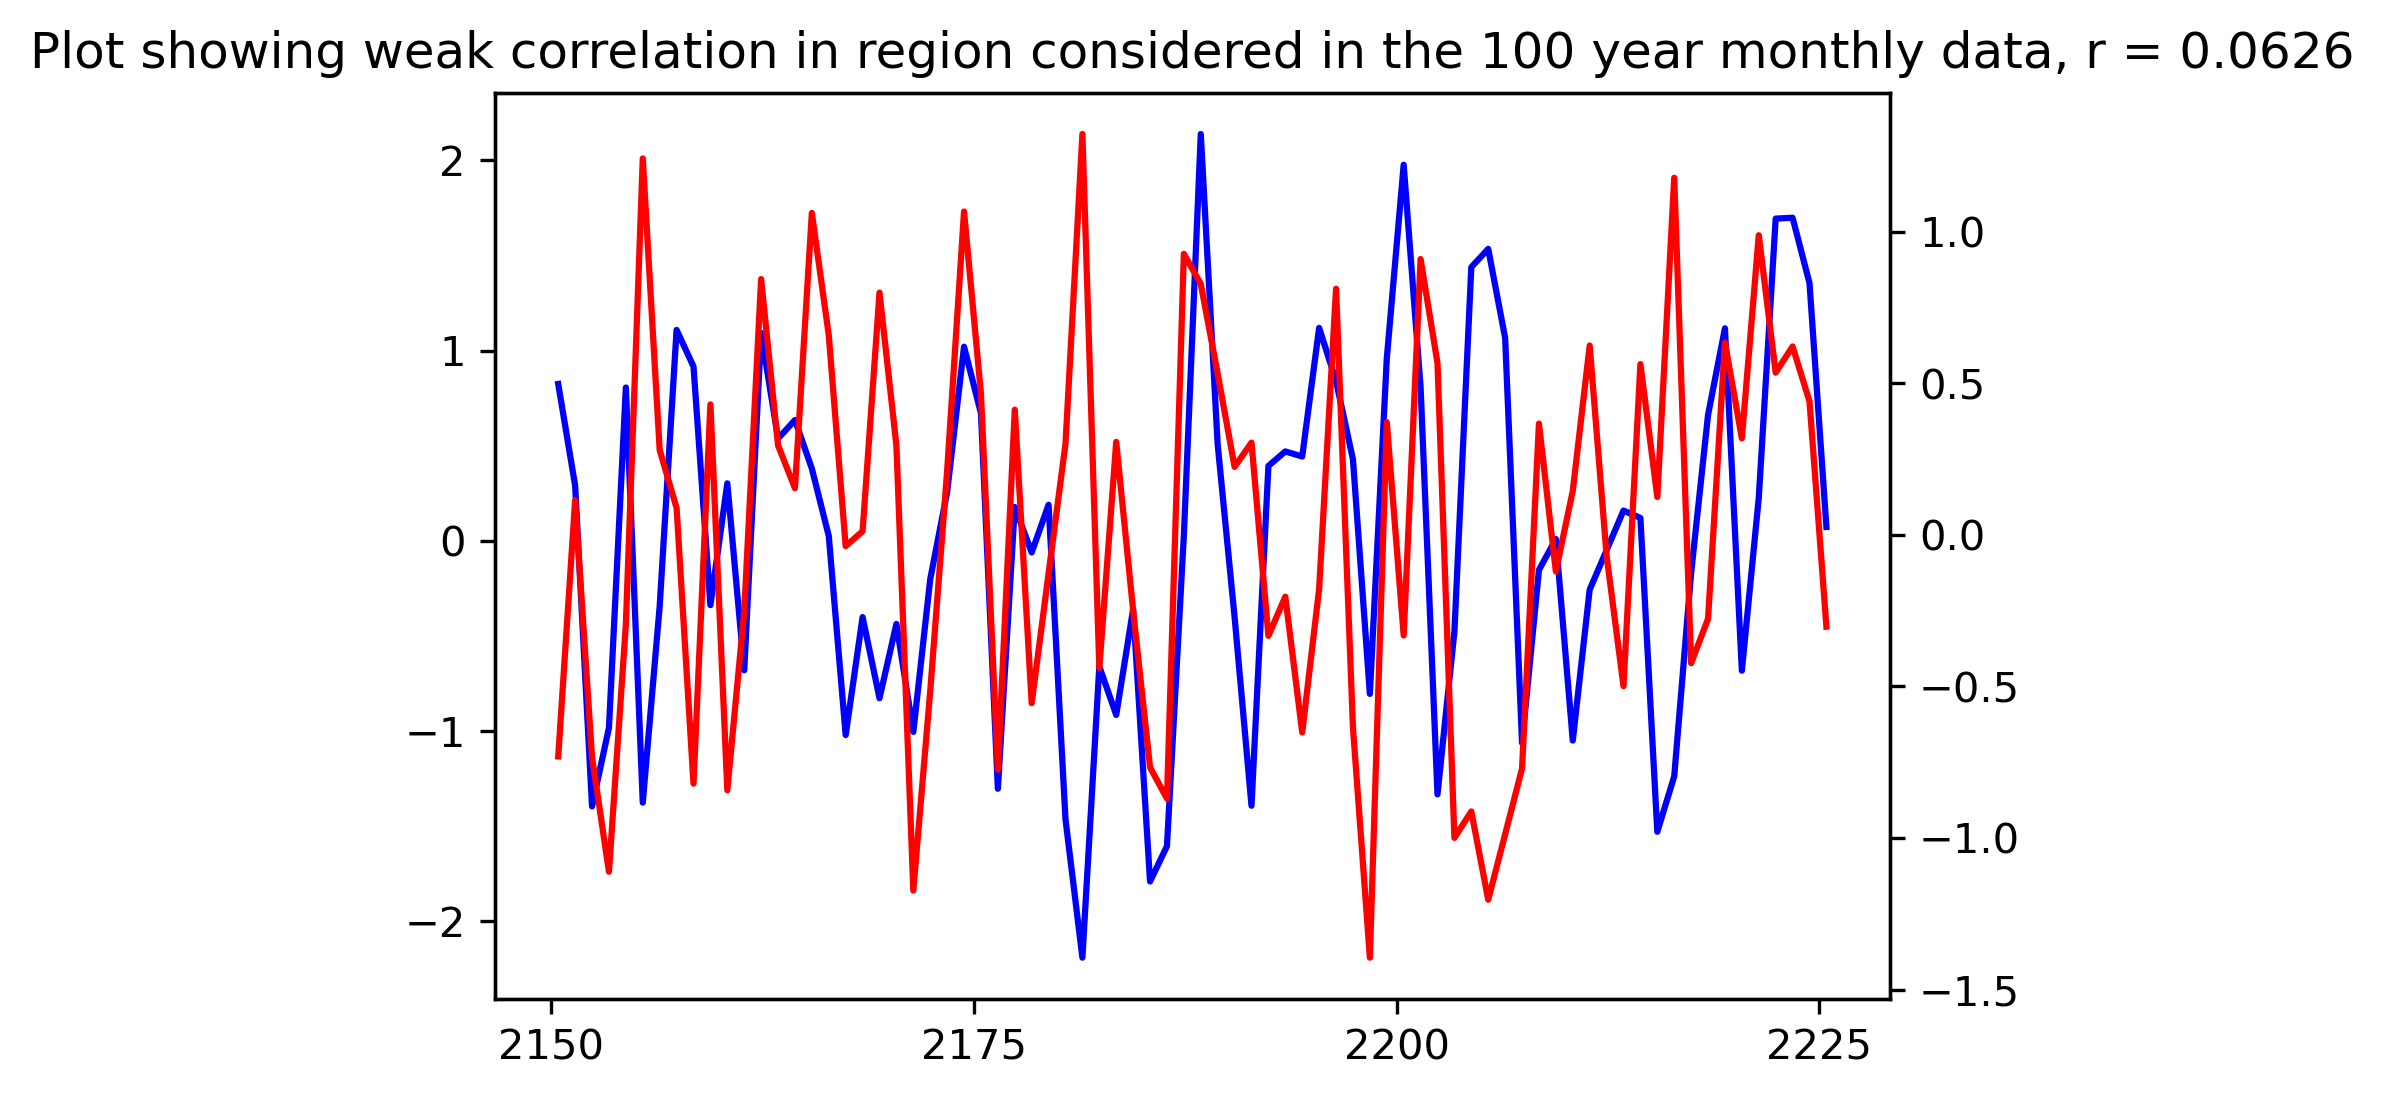

In [26]:
# Plot the questionable time period

fig = plt.figure(dpi=300)
ax = plt.axes()

ax.plot(time[198:274],test_pc,c='blue',label='PC in time period')
ax1 = ax.twinx()
ax1.plot(time[198:274],test_temp,c='red',label='Temp anomaly in time period')

plt.title('Plot showing weak correlation in region considered in the 100 year monthly data, r = 0.0626')

Text(0.5, 1.0, 'u-bh443: PC 1 and NINO3.4 anomalies (r=-0.73)')

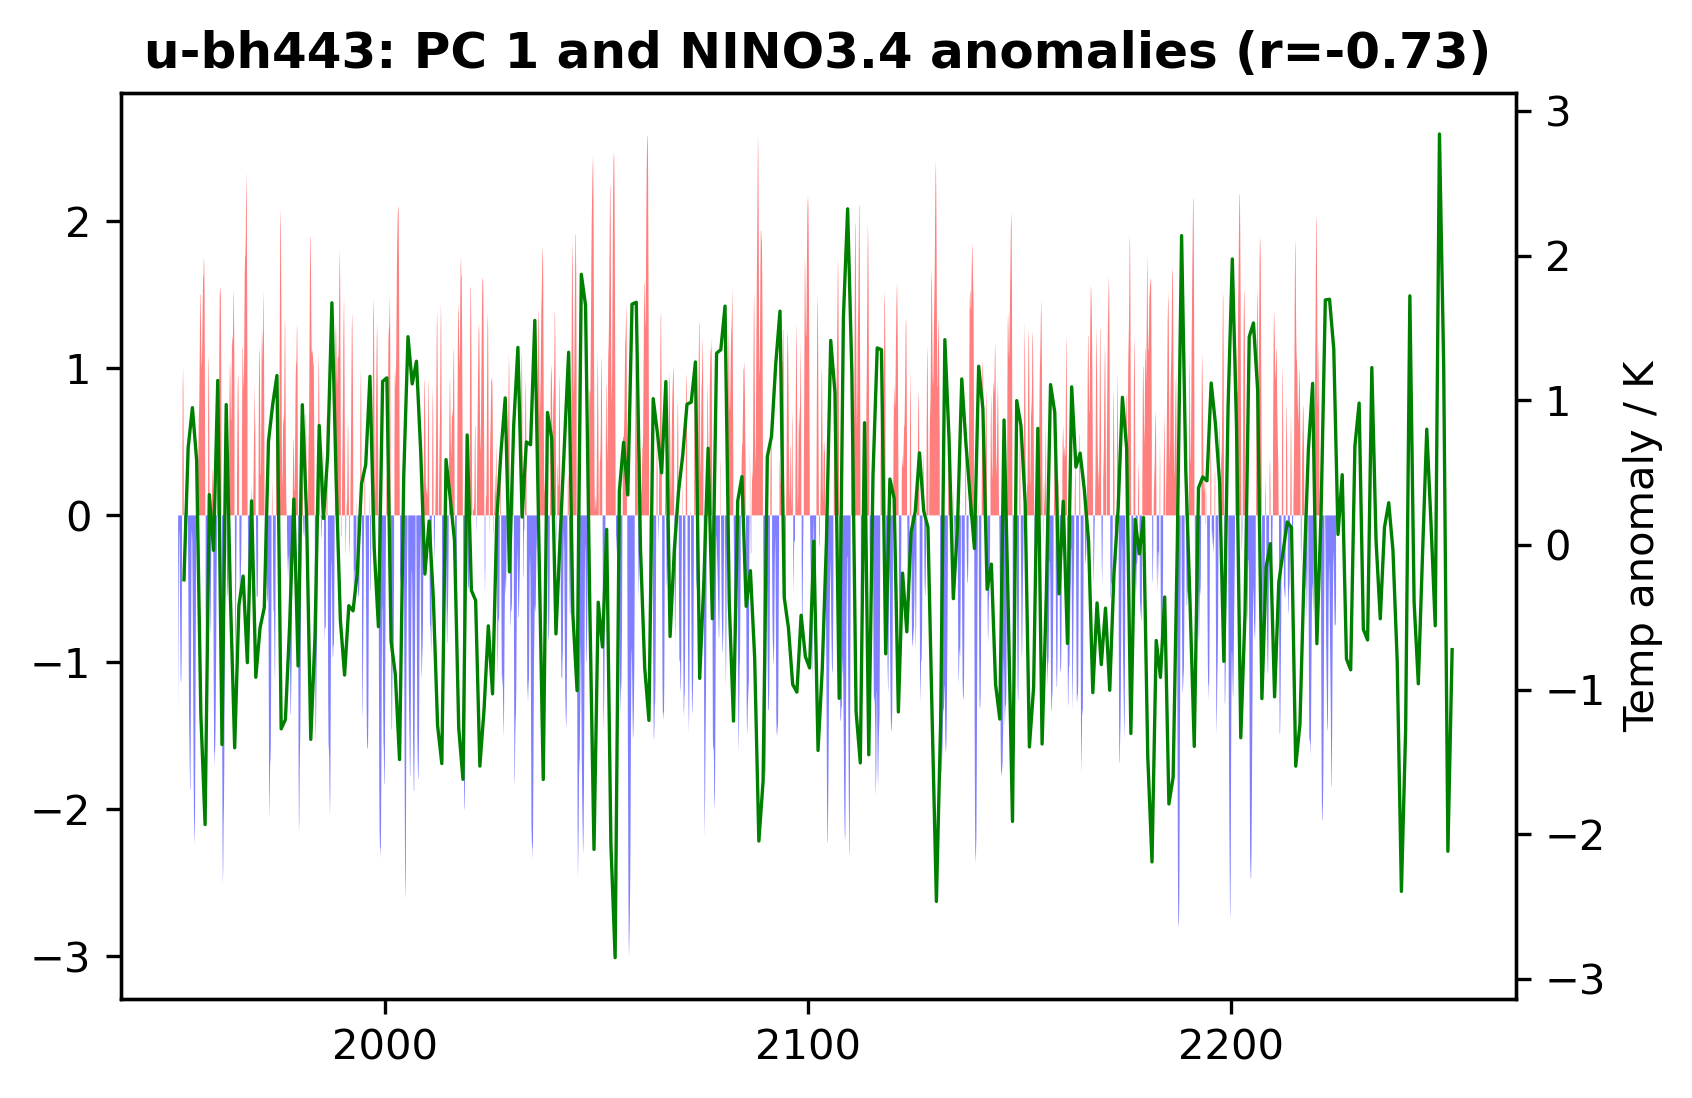

In [27]:
# Plot the nino temperature anomaly

fig = plt.figure(dpi=300)
ax = plt.axes()

# # line0, = ax.plot(time_949[:925], temp_anomaly_bl949, label = 'SST anomaly / K', c = 'k', linewidth = 1)
p1 = ax.fill_between(dtime_443, temp_anomaly_bh443, 0 ,where=(temp_anomaly_bh443 > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax.fill_between(dtime_443, temp_anomaly_bh443, 0 ,where=(temp_anomaly_bh443 < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax1 = ax.twinx()
ax1.set_ylabel('OH anomaly %', fontsize=10)
p3, = ax1.plot(oh_data_443.time,pcs[:,0], c='green', linewidth = 0.8,label='OH anomaly')

# ax.plot(oh_data_443.time[:274], res, label = 'SST anomaly / K', c = 'k', linewidth = 0.8)

# ax.set_xlim(dtime_443[2400],dtime_443[3288])

# ax.legend(handles=[p1,p2,p3],fontsize=5,loc ='upper right')
plt.xlabel('Time')
plt.ylabel(f'Temp anomaly / K')
plt.title('u-bh443: PC 1 and NINO3.4 anomalies (r=-0.73)',fontweight='bold')

Text(0.5, 1.0, 'PC1 with ENSO state, r = -0.73')

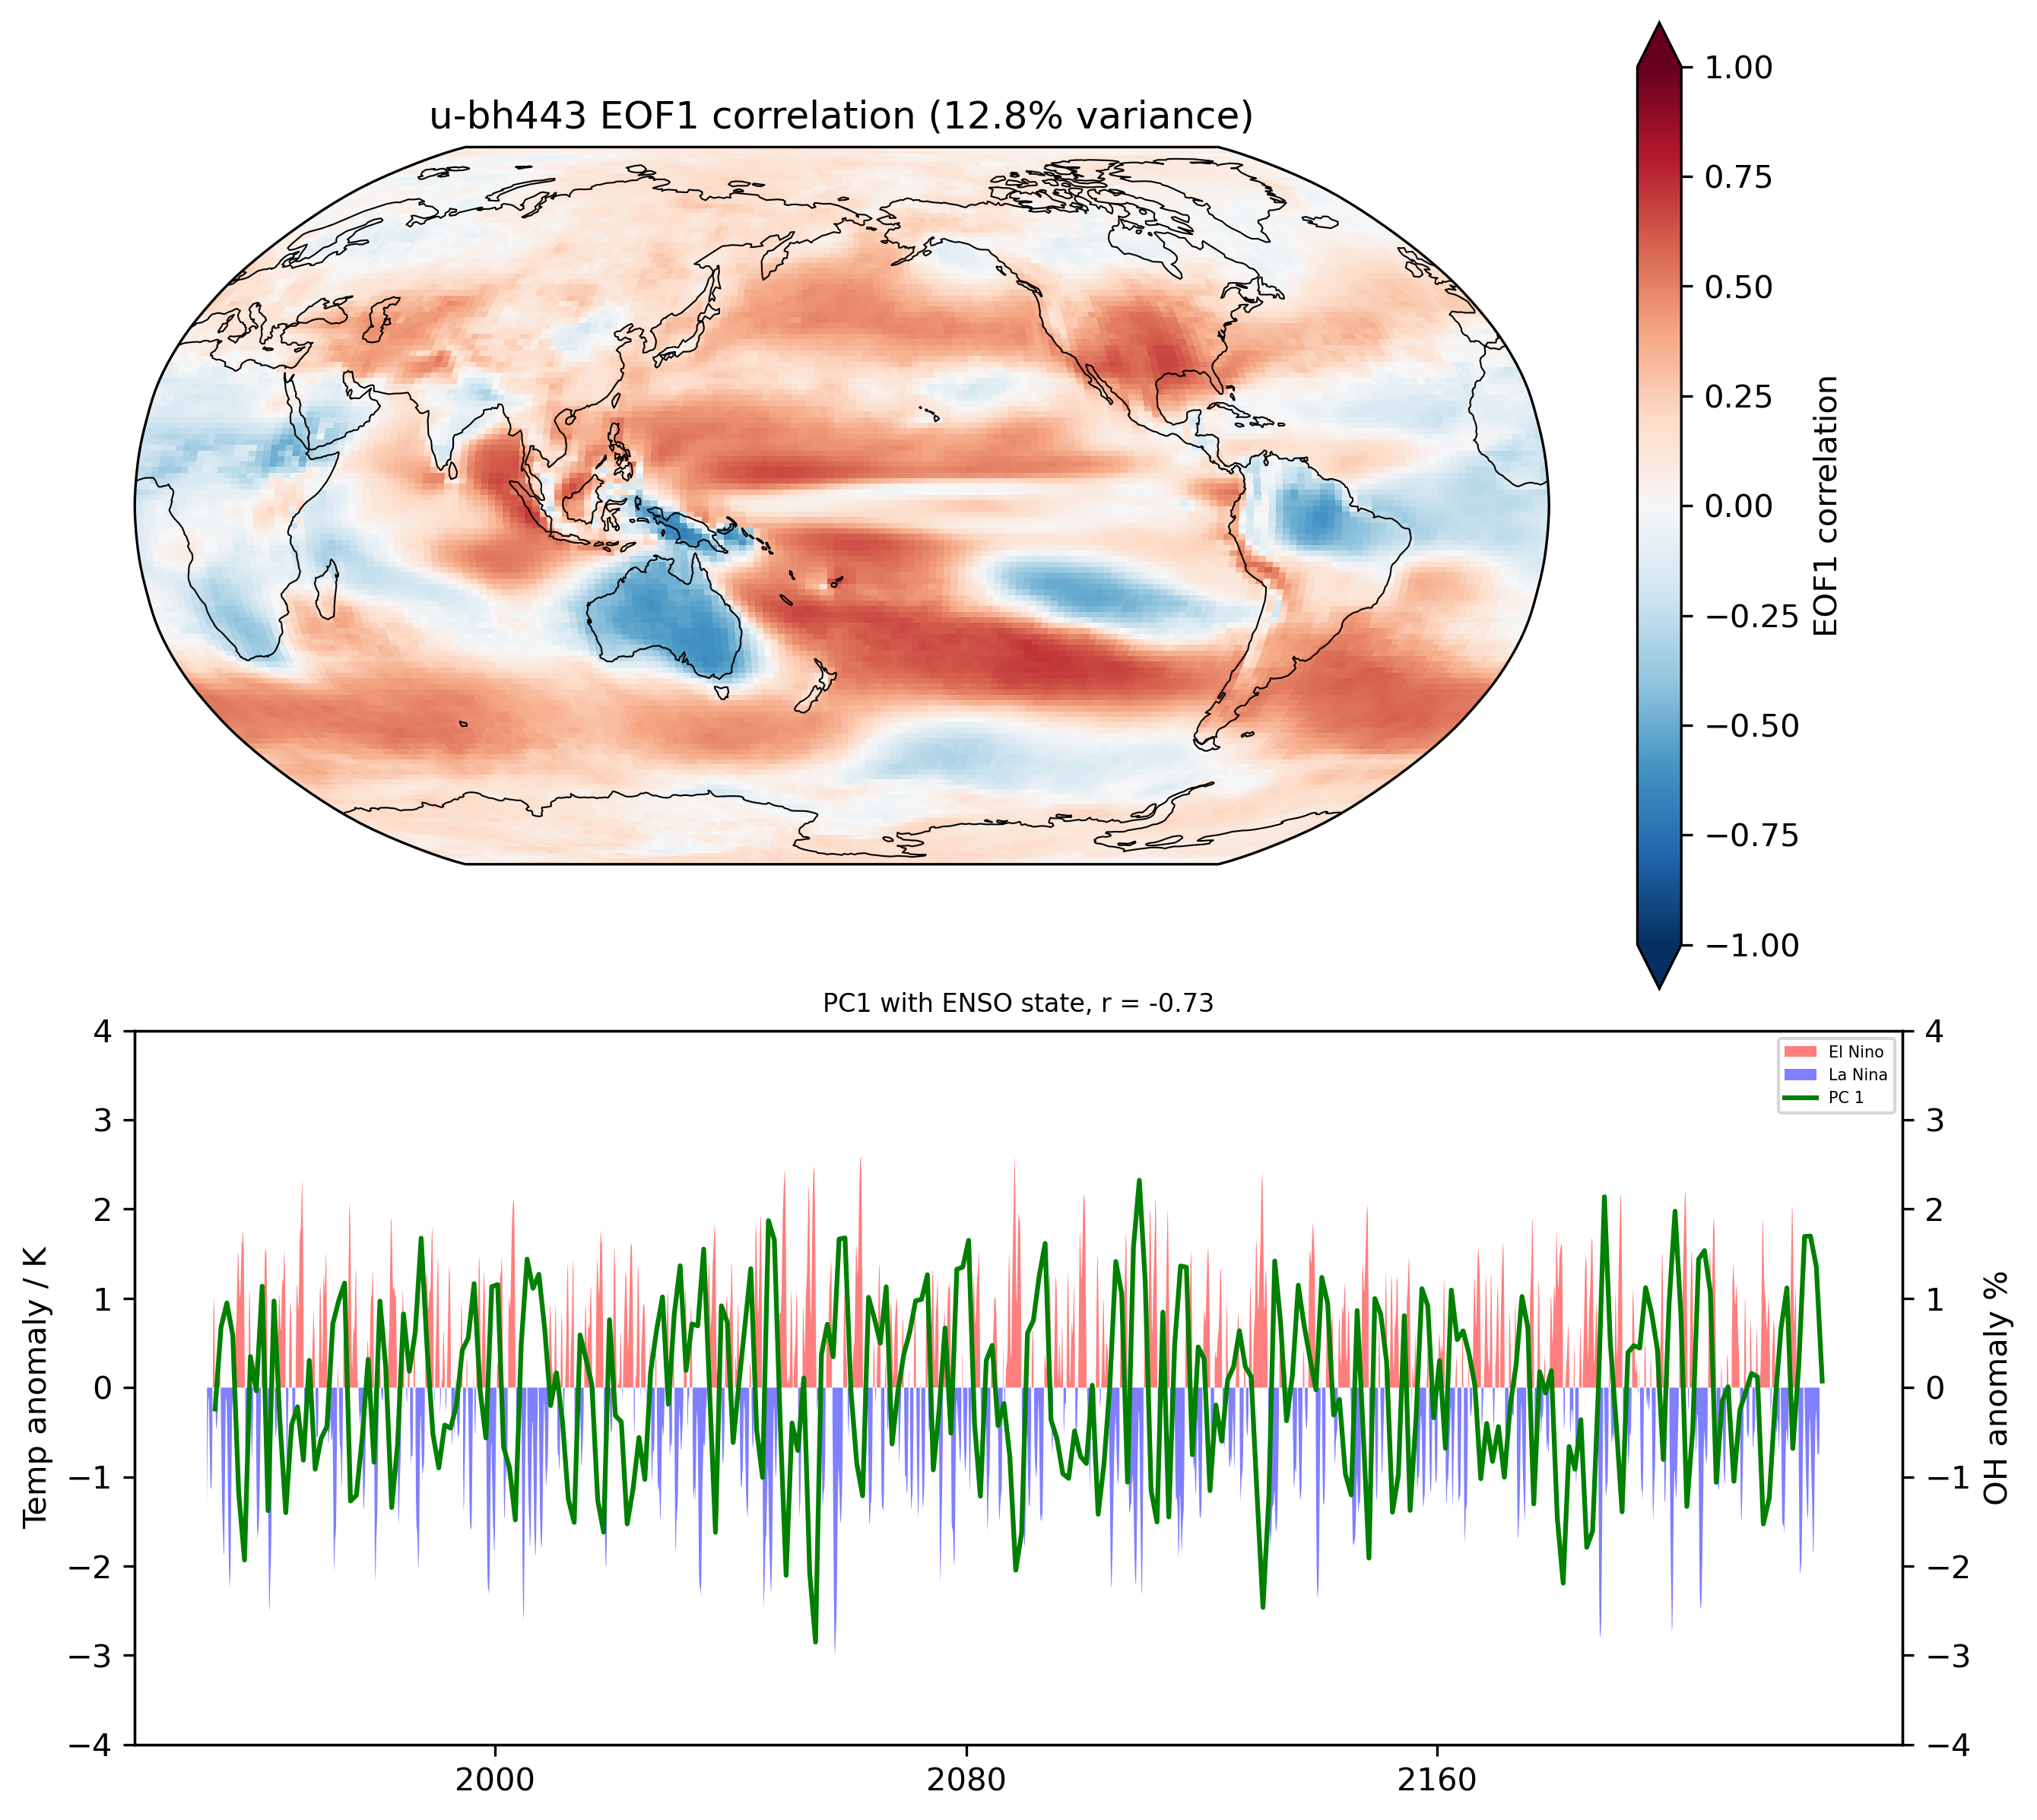

In [24]:
fig = plt.figure(figsize=(10,10),dpi=300)

ax = fig.add_subplot(7,1,(1,4),projection=ccrs.Robinson(central_longitude=180, globe=None))
ax.set_title('u-bh443 EOF1 correlation (12.8% variance)')
ax.coastlines(linewidth=0.5)
bh_cyclic, lon_plot = add_cyclic_point(eofs[0,:,:], coord=lon)   
c = ax.pcolormesh(lon_plot,lat,bh_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),vmin=-1,vmax=1)
cb = fig.colorbar(c, label= 'EOF1 correlation',extend='both',ax=ax)

ax1 = fig.add_subplot(7,1,(5,7))

p1 = ax1.fill_between(dtime_443, temp_anomaly_bh443, 0 ,where=(temp_anomaly_bh443 > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax1.fill_between(dtime_443, temp_anomaly_bh443, 0 ,where=(temp_anomaly_bh443 < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax2 = ax1.twinx()
ax2.set_ylabel('OH anomaly %', fontsize=10)
p3, = ax2.plot(time[:274],pcsuse, c='green', linewidth = 1.5,label='PC 1')

ax1.set_ylim(-4,4)
ax2.set_ylim(-4,4)

ax1.set_ylabel('Temp anomaly / K')
ax1.legend(handles=[p1,p2,p3],fontsize=5,loc ='upper right')
ax2.set_title('PC1 with ENSO state, r = -0.73',fontsize=8)